<a href="https://colab.research.google.com/github/christiansopov-gif/OMXS30_Projekt/blob/main/OMXS30_AI_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Projektidé**

Syftet är att undersöka om det går att använda maskininlärning för att förutsäga dagliga rörelser i OMXS30-indexet utifrån historisk data.
Målet är att förstå hur man hämtar, bearbetar och analyserar finansiell tidsseriedata och i nästa steg bygga en enkel modell som förutsäger om indexet går upp eller ner nästa handelsdag.

**Problemformulering**

Kan historiska mönster i OMXS30 ge en indikation på om marknaden stiger eller faller nästa dag?

**Typ av problem**

Detta är ett klassificeringsproblem där målet är att modellen ska förutsäga en kategori:

1 = uppgång

0 = nedgång

**Datakälla**

Data hämtas från Yahoo Finance med biblioteket yfinance
Ticker: ^OMX (OMXS30-indexet)

Kolumner:

Open = öppningskurs

High = högsta kurs

Low = lägsta kurs

Close = stängningskurs

Volume = omsättning

**Labeling och metod**

Datan är labeled eftersom varje handelsdag har ett faktiskt utfall.
Jag skapar labels själv genom att beräkna den procentuella förändringen i stängningskurs och sätta:

1 om nästa dags avkastning är positiv

0 om nästa dags avkastning är negativ

**Framtida utveckling**

I senare steg kan projektet utökas med reinforcement learning, där en agent lär sig köpa/sälja/avstå baserat på belöning:

-Belöning = positiv avkastning

-Bestraffning = negativ avkastning

Träningen kommer ske i Google Colab med bibliotek som scikit-learn och stable-baselines3.

In [1]:
#KODCELL 1

# Importera de bibliotek vi behöver
import yfinance as yf        # För att hämta aktiedata direkt från Yahoo Finance
import pandas as pd           # För att hantera och analysera data i tabellform (DataFrames)
import matplotlib.pyplot as plt  # För att skapa grafer och visualiseringar

# Hämta historisk data för OMXS30 från Yahoo Finance
# ^OMX = OMXS30-indexet
# Vi hämtar data från 2015 till 2024
data = yf.download("^OMX", start="2015-01-01", end="2024-12-31", progress=False)

# Skriver ut hur många rader (dagar) datat innehåller
print("Antal rader:", len(data))

# Visar de första raderna i tabellen för att se hur datat ser ut
data.head()


/tmp/ipython-input-3162134799.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("^OMX", start="2015-01-01", end="2024-12-31", progress=False)


Antal rader: 2511


Price             Close         High          Low         Open Volume
Ticker             ^OMX         ^OMX         ^OMX         ^OMX   ^OMX
Date                                                                 
2015-01-02  1463.780029  1472.609985  1460.670044  1470.550049      0
2015-01-05  1454.810059  1467.689941  1453.530029  1460.890015      0
2015-01-07  1421.339966  1441.310059  1421.339966  1432.300049      0
2015-01-08  1456.719971  1458.170044  1428.540039  1439.199951      0
2015-01-09  1444.459961  1460.989990  1439.150024  1453.510010      0

In [2]:
#KODCELL 2

# Undersök datat för att se datatyper och om något saknas

# Visar vilka datatyper varje kolumn har (float, int, datetime etc.)
print("\nDatatyper:\n", data.dtypes)

# Visar hur många saknade värden (NaN) som finns per kolumn
print("\nSaknade värden per kolumn:\n", data.isnull().sum())

# Visar grundläggande statistik (medelvärde, min, max, standardavvikelse etc.)
data.describe()



Datatyper:
 Price   Ticker
Close   ^OMX      float64
High    ^OMX      float64
Low     ^OMX      float64
Open    ^OMX      float64
Volume  ^OMX        int64
dtype: object

Saknade värden per kolumn:
 Price   Ticker
Close   ^OMX      0
High    ^OMX      0
Low     ^OMX      0
Open    ^OMX      0
Volume  ^OMX      0
dtype: int64


Price         Close         High          Low         Open        Volume
Ticker         ^OMX         ^OMX         ^OMX         ^OMX          ^OMX
count   2511.000000  2511.000000  2511.000000  2511.000000  2.511000e+03
mean    1849.864818  1860.973503  1837.683301  1849.826212  1.405814e+07
std      370.955796   371.893376   369.840805   370.919555  3.724420e+07
min     1246.099976  1286.670044  1240.680054  1247.000000  0.000000e+00
25%     1557.895020  1567.630005  1546.565002  1557.135010  0.000000e+00
50%     1687.170044  1695.939941  1675.969971  1687.689941  0.000000e+00
75%     2200.425049  2210.294922  2189.285034  2201.665039  0.000000e+00
max     2642.429932  2649.919922  2632.409912  2644.800049  3.050086e+08

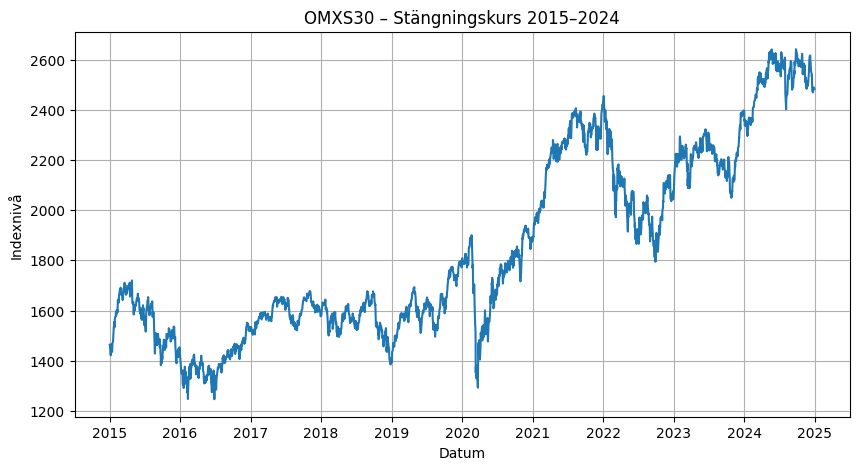

In [3]:
#KODCELL 3

#Rita graf över stängningskursen
# Skapar en figur i storleken 10x5 tum
plt.figure(figsize=(10,5))

# Plottar stängningskursen ("Close") över tid
plt.plot(data.index, data["Close"])

# Titel och etiketter
plt.title("OMXS30 – Stängningskurs 2015–2024")
plt.xlabel("Datum")
plt.ylabel("Indexnivå")

# Visar rutnät i bakgrunden för att lättare läsa grafen
plt.grid(True)

# Visar grafen
plt.show()



In [4]:
# Kodcell 4: Skapa nya kolumner för avkastning och målvariabel

# 1) Platta till kolumner om de är MultiIndex (t.ex. "Close  ^OMX")
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# 2) Ta bort ev. gamla kolumner från tidigare försök
for col in ["Return", "Target"]:
    if col in data.columns:
        data = data.drop(columns=col)

# 3) Räkna avkastning på stängningskurs
data["Return"] = data["Close"].pct_change()

# 4) Målvariabel: 1 om NÄSTA dags avkastning > 0, annars 0
data["Target"] = (data["Return"].shift(-1) > 0).astype(int)

# 5) Droppa bara rader där våra nya kolumner är NaN (inte hela raden på allt)
data = data.dropna(subset=["Return", "Target"])

print("Antal observationer efter rensning:", len(data))
data.head()


Antal observationer efter rensning: 2510


Price             Close         High          Low         Open  Volume  \
Date                                                                     
2015-01-05  1454.810059  1467.689941  1453.530029  1460.890015       0   
2015-01-07  1421.339966  1441.310059  1421.339966  1432.300049       0   
2015-01-08  1456.719971  1458.170044  1428.540039  1439.199951       0   
2015-01-09  1444.459961  1460.989990  1439.150024  1453.510010       0   
2015-01-12  1453.640015  1460.109985  1444.550049  1455.540039       0   

Price         Return  Target  
Date                          
2015-01-05 -0.006128       0  
2015-01-07 -0.023007       1  
2015-01-08  0.024892       0  
2015-01-09 -0.008416       1  
2015-01-12  0.006355       1

In [5]:
#Kodcell 5: Kontrollera datakvalitet efter bearbetning

# Kollar om det finns några saknade värden kvar efter att vi skapat våra kolumner
print("Null-värden efter bearbetning:\n", data.isnull().sum())

# Rensar bort eventuella rader med null-värden (de första pga .pct_change())
data = data.dropna()

# Skriver ut hur många rader som återstår efter rensning
print("\nAntal observationer efter rensning:", len(data))


Null-värden efter bearbetning:
 Price
Close     0
High      0
Low       0
Open      0
Volume    0
Return    0
Target    0
dtype: int64

Antal observationer efter rensning: 2510


Fördelning av målvariabel (Target):
Nedgång (0): 1187 dagar
Uppgång  (1): 1323 dagar


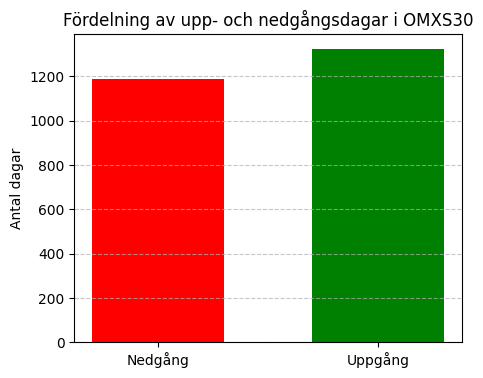

In [6]:
# Kodcell 5: Visa hur många dagar som var uppgång respektive nedgång

# Räkna antal förekomster av 0 och 1
count = data["Target"].value_counts().sort_index()

# Skriv ut siffrorna i textform
print("Fördelning av målvariabel (Target):")
print(f"Nedgång (0): {count.get(0, 0)} dagar")
print(f"Uppgång  (1): {count.get(1, 0)} dagar")

# Rita ett enkelt stapeldiagram
plt.figure(figsize=(5,4))
plt.bar(count.index, count.values, color=["red","green"], width=0.6)
plt.xticks([0,1], ["Nedgång","Uppgång"])
plt.title("Fördelning av upp- och nedgångsdagar i OMXS30")
plt.ylabel("Antal dagar")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [8]:
# Kodcell6: Lägg till utvalda indikatorer (MA5, MA20, RSI14, Volatility10, Weekday)

import numpy as np

# Säker utplock av Close-serien
if isinstance(data.columns, pd.MultiIndex):
    close = data['Close'].iloc[:, 0]
else:
    close = data['Close']

# 1) Trend
data["MA5"] = close.rolling(5).mean()
data["MA20"] = close.rolling(20).mean()

# 2) Momentum RSI14
delta = close.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / (avg_loss.replace(0, np.nan))
data["RSI14"] = 100 - (100 / (1 + rs))

# 3) Volatilitet 10 dagar på din Return-kolumn
# Antag att data["Return"] redan finns från Kodcell 4
data["Volatility10"] = data["Return"].rolling(10).std()

# 4) Veckodag
data["Weekday"] = data.index.weekday  # 0=mån ... 4=fre

# Rensa rader där nya features inte kan beräknas i början
feat_cols = ["MA5", "MA20", "RSI14", "Volatility10", "Weekday", "Return", "Target"]
data_feat = data.dropna(subset=["MA20", "RSI14", "Volatility10", "Return", "Target"]).copy()

print("Kvar efter feature-beräkning:", len(data_feat))
data_feat[["Close", "Return", "Target", "MA5", "MA20", "RSI14", "Volatility10", "Weekday"]].head()


Kvar efter feature-beräkning: 2490


Price             Close    Return  Target          MA5         MA20  \
Date                                                                  
2015-02-02  1575.949951  0.001481       1  1563.173999  1497.878003   
2015-02-03  1593.420044  0.011085       0  1575.184009  1504.808502   
2015-02-04  1579.310059 -0.008855       1  1578.538013  1512.707007   
2015-02-05  1586.130005  0.004318       1  1581.686011  1519.177509   
2015-02-06  1599.550049  0.008461       0  1586.872021  1526.932013   

Price           RSI14  Volatility10  Weekday  
Date                                          
2015-02-02  75.685875      0.009024        0  
2015-02-03  89.403366      0.009061        1  
2015-02-04  81.621143      0.010308        2  
2015-02-05  81.159977      0.009702        3  
2015-02-06  81.743270      0.009712        4

Rader kvar efter indikatorer: 2490


Price             Close    Return  Target          MA5         MA20  \
Date                                                                  
2015-02-02  1575.949951  0.001481       1  1563.173999  1497.878003   
2015-02-03  1593.420044  0.011085       0  1575.184009  1504.808502   
2015-02-04  1579.310059 -0.008855       1  1578.538013  1512.707007   
2015-02-05  1586.130005  0.004318       1  1581.686011  1519.177509   
2015-02-06  1599.550049  0.008461       0  1586.872021  1526.932013   

Price           RSI14  Volatility10  Weekday  
Date                                          
2015-02-02  75.685875      0.009024        0  
2015-02-03  89.403366      0.009061        1  
2015-02-04  81.621143      0.010308        2  
2015-02-05  81.159977      0.009702        3  
2015-02-06  81.743270      0.009712        4

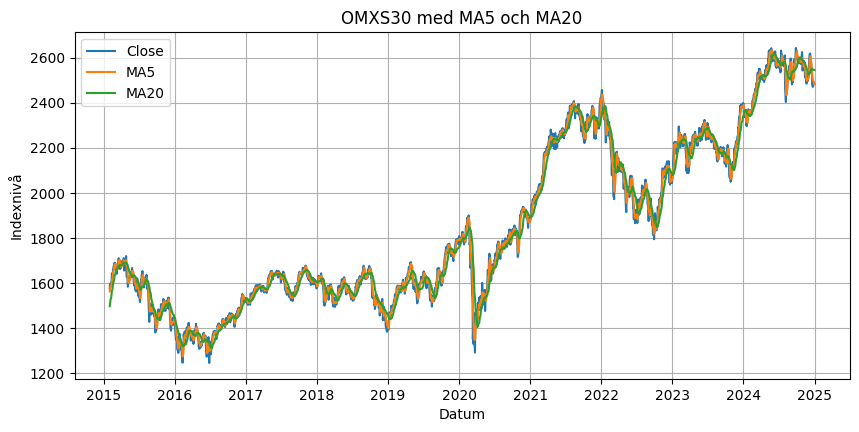

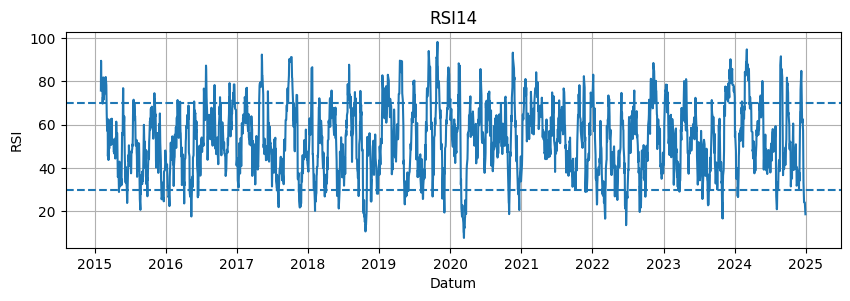

In [9]:
# Kodcell 7: Indikatorer + kontroll (MA5, MA20, RSI14, Volatility10, Weekday)

import numpy as np

# Säker utplock av Close-serien
if isinstance(data.columns, pd.MultiIndex):
    close = data['Close'].iloc[:, 0]
else:
    close = data['Close']

# 1) Trend
data["MA5"] = close.rolling(5).mean()
data["MA20"] = close.rolling(20).mean()

# 2) RSI14 (enkel variant)
delta = close.diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss.replace(0, np.nan)
data["RSI14"] = 100 - (100 / (1 + rs))

# 3) Volatilitet 10 dagar på Return
# Return och Target skapades i din Kodcell 4
data["Volatility10"] = data["Return"].rolling(10).std()

# 4) Veckodag
data["Weekday"] = data.index.weekday  # 0=mån ... 4=fre

# Rensa rader där indikatorerna inte kan beräknas ännu
need = ["MA20", "RSI14", "Volatility10", "Return", "Target"]
data_feat = data.dropna(subset=need).copy()

print("Rader kvar efter indikatorer:", len(data_feat))
cols = ["Close","Return","Target","MA5","MA20","RSI14","Volatility10","Weekday"]
display(data_feat[cols].head())

# Snabb visuell check: Close med MA5 och MA20
plt.figure(figsize=(10,4.5))
plt.plot(data_feat.index, data_feat["Close"], label="Close")
plt.plot(data_feat.index, data_feat["MA5"], label="MA5")
plt.plot(data_feat.index, data_feat["MA20"], label="MA20")
plt.title("OMXS30 med MA5 och MA20")
plt.xlabel("Datum"); plt.ylabel("Indexnivå"); plt.grid(True); plt.legend(); plt.show()

# Snabb visuell check: RSI14
plt.figure(figsize=(10,2.8))
plt.plot(data_feat.index, data_feat["RSI14"])
plt.axhline(70, linestyle="--"); plt.axhline(30, linestyle="--")
plt.title("RSI14"); plt.xlabel("Datum"); plt.ylabel("RSI"); plt.grid(True); plt.show()
